# Tarea N°2 - Máquinas de Aprendizaje - ILI393
### Martín Villanueva A.

## Introducción

## Parte 1 - Evaluación de Créditos

### 1) Linear Discriminant Analysis

##############################################################
Dataset: 2
Training error: 0.0222222222222
Testing error: 0.133333333333
##############################################################


##############################################################
Dataset: 15
Training error: 0.0555555555556
Testing error: 0.1
##############################################################




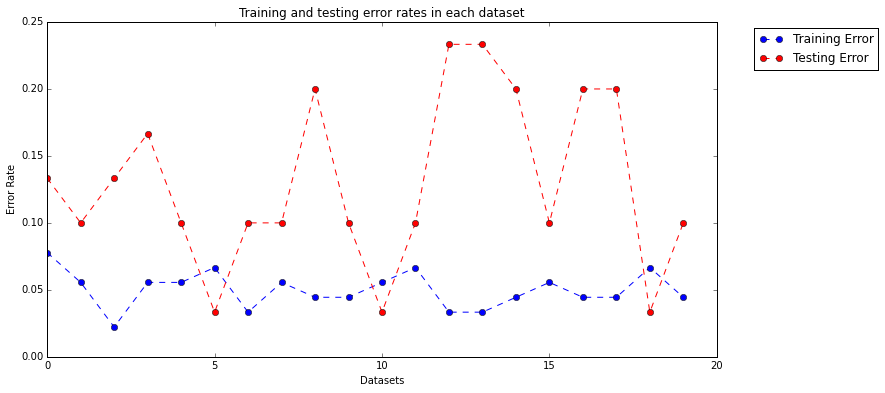

In [11]:
lda = LDA()
lda_tr_err, lda_ts_err = solve_clf(lda, 'credit', data_func=normalize, show=[2,15])

### 2) Estimación alternativa de parámetros en LDA

##############################################################
Dataset: 2
Training error: 0.0444444444444
Testing error: 0.166666666667
##############################################################


##############################################################
Dataset: 15
Training error: 0.0666666666667
Testing error: 0.1
##############################################################




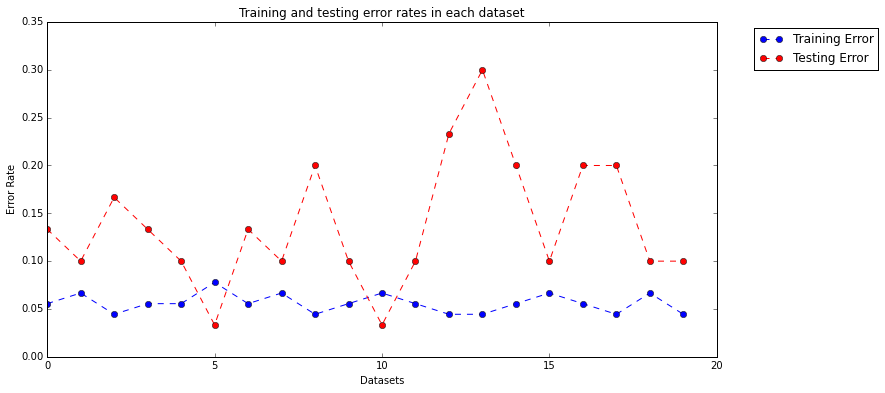

In [12]:
mlda = LDA(alternative=True)
mlda_tr_err, mlda_ts_err = solve_clf(mlda, 'credit', data_func=normalize, show=[2,15])

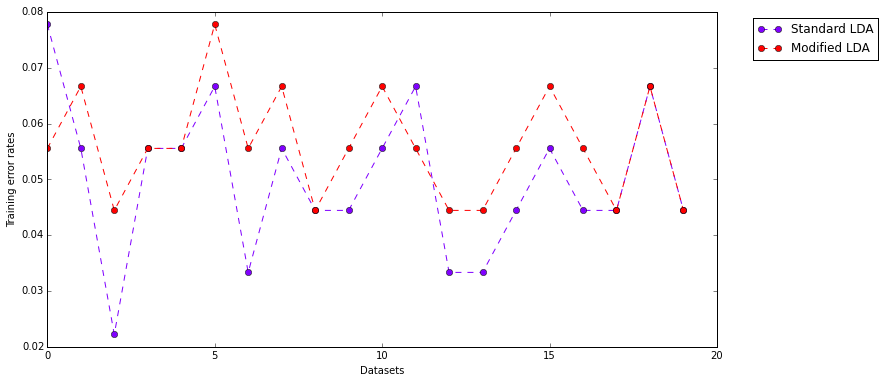

In [51]:
comparative_plot([lda_tr_err, mlda_tr_err],['Standard LDA', 'Modified LDA'], err_type='Training')

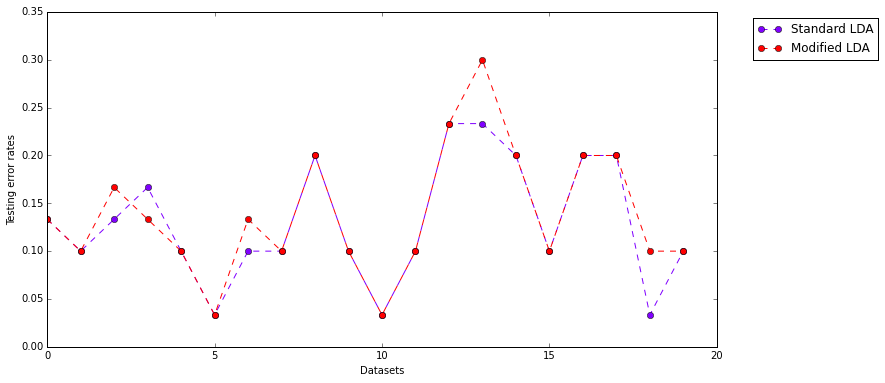

In [52]:
comparative_plot([lda_ts_err, mlda_ts_err],['Standard LDA', 'Modified LDA'], err_type='Testing')

### 3) Naive Bayes

### 4) Métodos de discretización en Naive Bayes

In [13]:
nb_params = {'nbins':np.array([2,4,6,8,10,12,14,16,18,20])}

##############################################################
Dataset: 2
Best parameter: {'nbins': 18}
CV scores:
mean: 0.85556, std: 0.07782, params: {'nbins': 2}
mean: 0.80000, std: 0.05730, params: {'nbins': 4}
mean: 0.81111, std: 0.09795, params: {'nbins': 6}
mean: 0.84444, std: 0.02309, params: {'nbins': 8}
mean: 0.83333, std: 0.04581, params: {'nbins': 10}
mean: 0.83333, std: 0.05908, params: {'nbins': 12}
mean: 0.83333, std: 0.06468, params: {'nbins': 14}
mean: 0.81111, std: 0.03228, params: {'nbins': 16}
mean: 0.86667, std: 0.04211, params: {'nbins': 18}
mean: 0.74444, std: 0.06730, params: {'nbins': 20}
Training error: 0.0666666666667
Testing error: 0.233333333333
##############################################################


##############################################################
Dataset: 15
Best parameter: {'nbins': 6}
CV scores:
mean: 0.80000, std: 0.07112, params: {'nbins': 2}
mean: 0.77778, std: 0.07359, params: {'nbins': 4}
mean: 0.82222, std: 0.07583, params: 

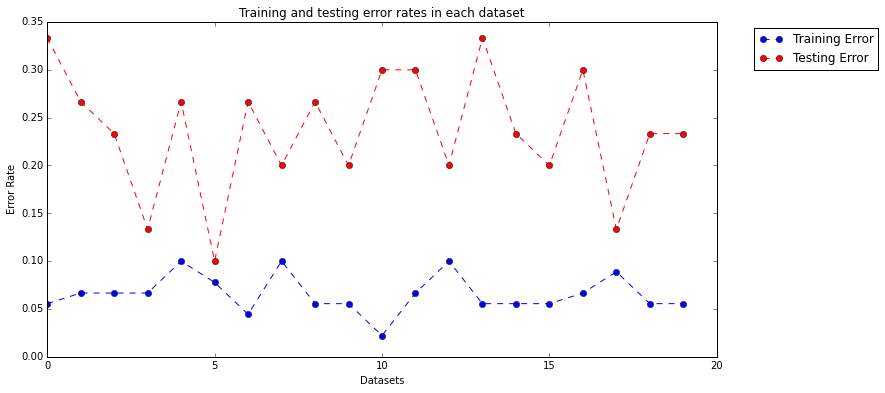

In [14]:
nb = NB(features=[0,1,2,3,5], disc_type='EWD')
ewd_nb_tr_err, ewd_nb_ts_err = solve_clf(nb, 'credit', params=nb_params, show=[2,15])

##############################################################
Dataset: 2
Best parameter: {'nbins': 2}
CV scores:
mean: 0.85556, std: 0.08861, params: {'nbins': 2}
mean: 0.84444, std: 0.08725, params: {'nbins': 4}
mean: 0.77778, std: 0.08453, params: {'nbins': 6}
mean: 0.78889, std: 0.05739, params: {'nbins': 8}
mean: 0.78889, std: 0.06679, params: {'nbins': 10}
mean: 0.73333, std: 0.03805, params: {'nbins': 12}
mean: 0.73333, std: 0.08375, params: {'nbins': 14}
mean: 0.74444, std: 0.06386, params: {'nbins': 16}
mean: 0.58889, std: 0.07439, params: {'nbins': 18}
mean: 0.66667, std: 0.12271, params: {'nbins': 20}
Training error: 0.0666666666667
Testing error: 0.266666666667
##############################################################


##############################################################
Dataset: 15
Best parameter: {'nbins': 2}
CV scores:
mean: 0.83333, std: 0.07772, params: {'nbins': 2}
mean: 0.82222, std: 0.10460, params: {'nbins': 4}
mean: 0.80000, std: 0.13368, params: {

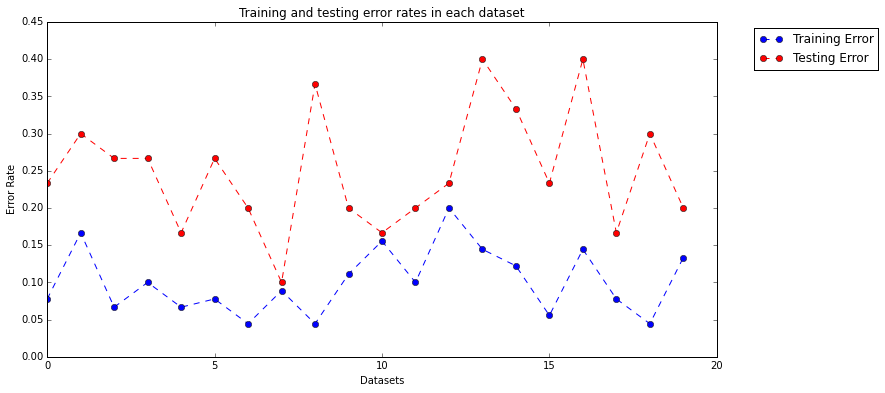

In [15]:
nb = NB(features=[0,1,2,3,5], disc_type='EFD')
efd_nb_tr_err, efd_nb_ts_err = solve_clf(nb, 'credit', params=nb_params, show=[2,15])

##############################################################
Dataset: 2
Training error: 0.155555555556
Testing error: 0.233333333333
##############################################################


##############################################################
Dataset: 15
Training error: 0.188888888889
Testing error: 0.2
##############################################################




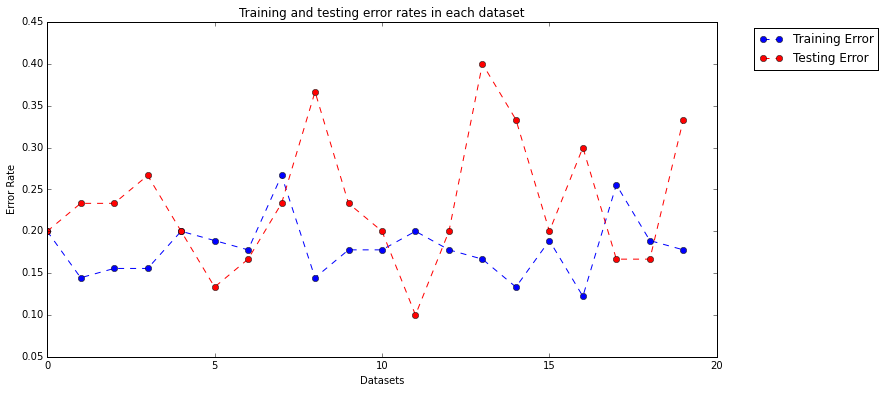

In [16]:
nb = NB(features=[0,1,2,3,5], disc_type='Gauss')
gs_nb_tr_err, gs_nb_ts_err = solve_clf(nb, 'credit', show=[2,15])

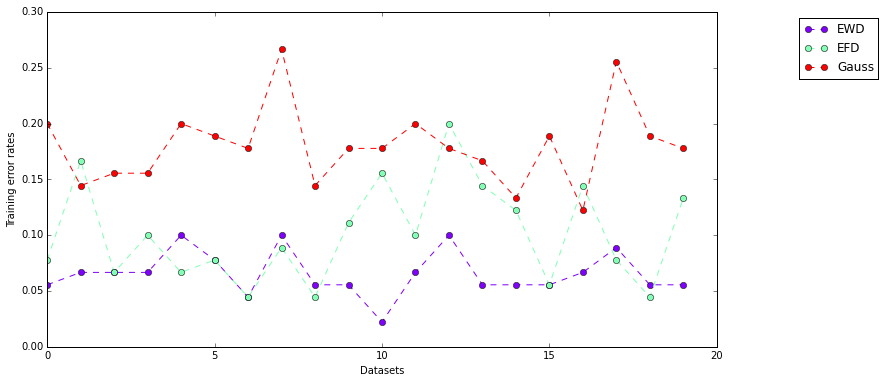

In [53]:
errors = [ewd_nb_tr_err, efd_nb_tr_err, gs_nb_tr_err]
labels = ['EWD', 'EFD', 'Gauss']
comparative_plot(errors, labels, err_type='Training')

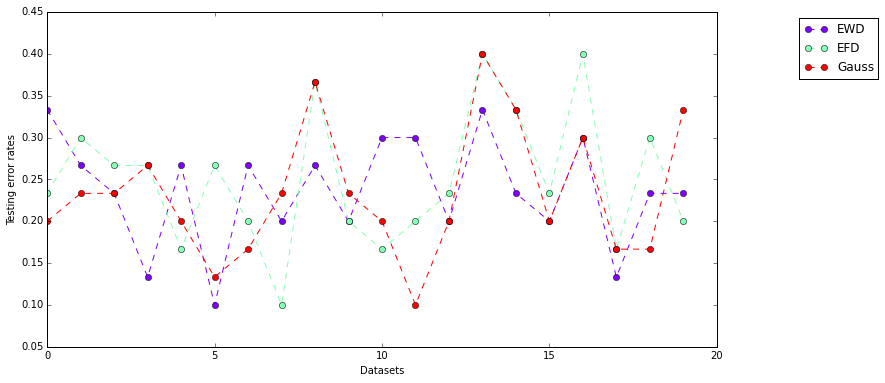

In [54]:
errors = [ewd_nb_ts_err, efd_nb_ts_err, gs_nb_ts_err]
labels = ['EWD', 'EFD', 'Gauss']
comparative_plot(errors, labels, err_type='Testing')

### 5) Perceptrón Primal

In [17]:
#parameters to try on primal perceptron
pp_params = {'eta':np.linspace(1e0, 1e2, 5, endpoint=True)}

##############################################################
Dataset: 2
Best parameter: {'eta': 1.0}
CV scores:
mean: 0.95556, std: 0.05303, params: {'eta': 1.0}
mean: 0.95556, std: 0.05303, params: {'eta': 25.75}
mean: 0.95556, std: 0.05303, params: {'eta': 50.5}
mean: 0.95556, std: 0.05303, params: {'eta': 75.25}
mean: 0.95556, std: 0.05303, params: {'eta': 100.0}
Training error: 0.0
Testing error: 0.133333333333
##############################################################


##############################################################
Dataset: 15
Best parameter: {'eta': 1.0}
CV scores:
mean: 0.92222, std: 0.07555, params: {'eta': 1.0}
mean: 0.92222, std: 0.07555, params: {'eta': 25.75}
mean: 0.92222, std: 0.07555, params: {'eta': 50.5}
mean: 0.92222, std: 0.07555, params: {'eta': 75.25}
mean: 0.92222, std: 0.07555, params: {'eta': 100.0}
Training error: 0.0444444444444
Testing error: 0.233333333333
##############################################################




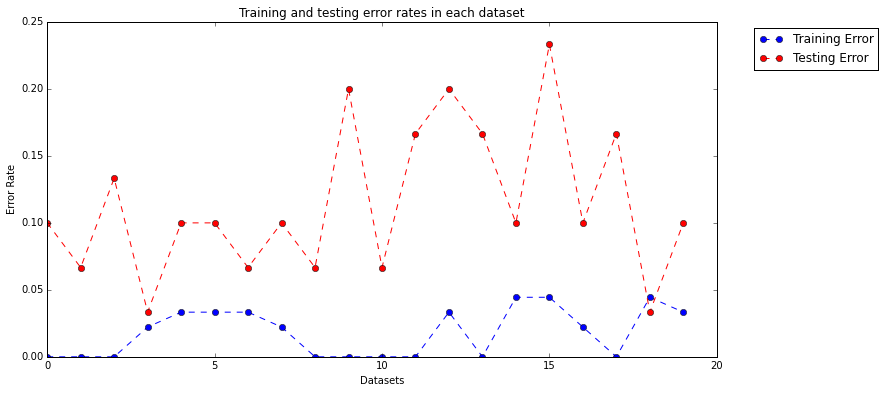

In [19]:
pp = PP()
pp_tr_err, pp_ts_err = solve_clf(pp, 'credit', params=pp_params, data_func=normalize, show=[2,15])

### 6) Nu-SVM con kernel lineal

In [21]:
#parameters to try on Nu-SVM with linear kernel
lsvm_params = {'nu':np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])}

##############################################################
Dataset: 2
Best parameter: {'nu': 0.10000000000000001}
CV scores:
mean: 0.96667, std: 0.04241, params: {'nu': 0.10000000000000001}
mean: 0.94444, std: 0.06938, params: {'nu': 0.20000000000000001}
mean: 0.94444, std: 0.06938, params: {'nu': 0.29999999999999999}
mean: 0.94444, std: 0.06938, params: {'nu': 0.40000000000000002}
mean: 0.93333, std: 0.07955, params: {'nu': 0.5}
mean: 0.90000, std: 0.06305, params: {'nu': 0.59999999999999998}
mean: 0.88889, std: 0.05934, params: {'nu': 0.69999999999999996}
Training error: 0.0222222222222
Testing error: 0.166666666667
##############################################################


##############################################################
Dataset: 15
Best parameter: {'nu': 0.29999999999999999}
CV scores:
mean: 0.91111, std: 0.07578, params: {'nu': 0.10000000000000001}
mean: 0.91111, std: 0.05870, params: {'nu': 0.20000000000000001}
mean: 0.92222, std: 0.02536, params: {'nu': 0

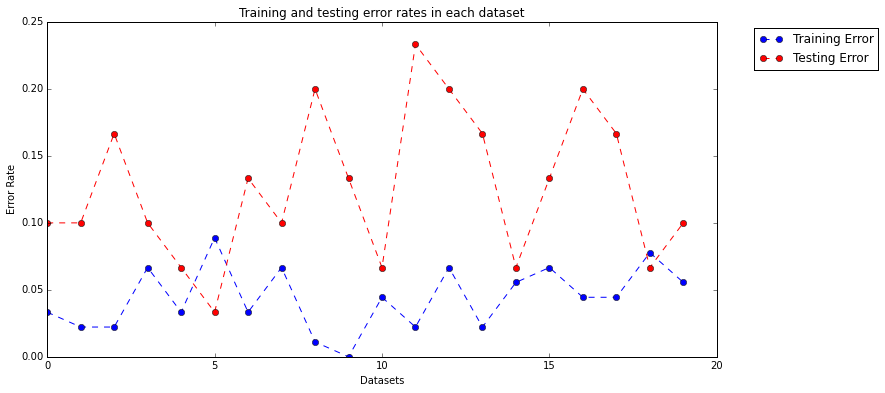

In [22]:
lsvm = svm.NuSVC(kernel='linear')
lsvm_tr_err, lsvm_ts_err = solve_clf(lsvm, 'credit', params=lsvm_params, data_func=normalize, show=[2,15])

### 7) Comparación de resultados

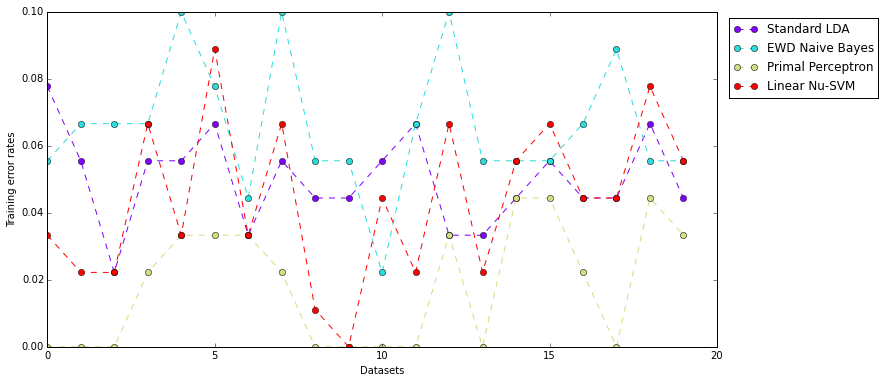

In [56]:
errors = [lda_tr_err, ewd_nb_tr_err, pp_tr_err, lsvm_tr_err]
labels = ['Standard LDA', 'EWD Naive Bayes', 'Primal Perceptron', 'Linear Nu-SVM']
comparative_plot(errors, labels, err_type='Training')

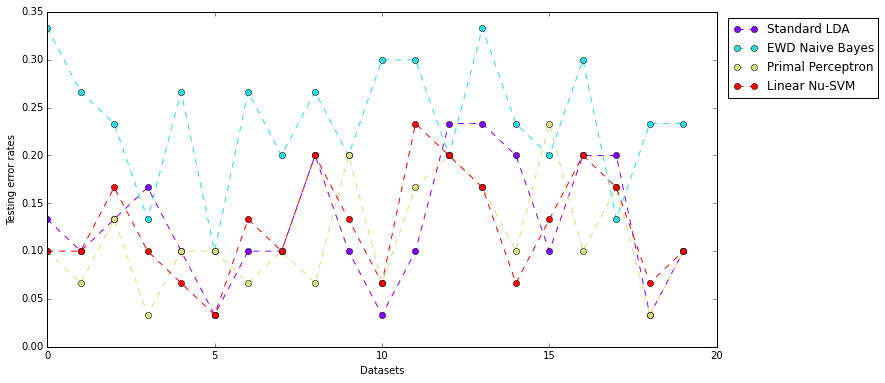

In [57]:
errors = [lda_ts_err, ewd_nb_ts_err, pp_ts_err, lsvm_ts_err]
labels = ['Standard LDA', 'EWD Naive Bayes', 'Primal Perceptron', 'Linear Nu-SVM']
comparative_plot(errors, labels, err_type='Testing')

## Parte 2 - Pima Indians Diabetes

### 1) Naive Bayes

In [23]:
nb_params = {'nbins':np.array([10,12,14,16,18,20,22,24,26,28,30])}

##############################################################
Dataset: 2
Best parameter: {'nbins': 16}
CV scores:
mean: 0.71701, std: 0.03889, params: {'nbins': 10}
mean: 0.72917, std: 0.03362, params: {'nbins': 12}
mean: 0.73264, std: 0.03985, params: {'nbins': 14}
mean: 0.74479, std: 0.04868, params: {'nbins': 16}
mean: 0.73785, std: 0.02669, params: {'nbins': 18}
mean: 0.72569, std: 0.04095, params: {'nbins': 20}
mean: 0.73611, std: 0.02812, params: {'nbins': 22}
mean: 0.72049, std: 0.03272, params: {'nbins': 24}
mean: 0.72396, std: 0.02294, params: {'nbins': 26}
mean: 0.73438, std: 0.04404, params: {'nbins': 28}
mean: 0.73438, std: 0.03492, params: {'nbins': 30}
Training error: 0.206597222222
Testing error: 0.25
##############################################################


##############################################################
Dataset: 15
Best parameter: {'nbins': 18}
CV scores:
mean: 0.73958, std: 0.03080, params: {'nbins': 10}
mean: 0.72917, std: 0.02094, params: {'nb

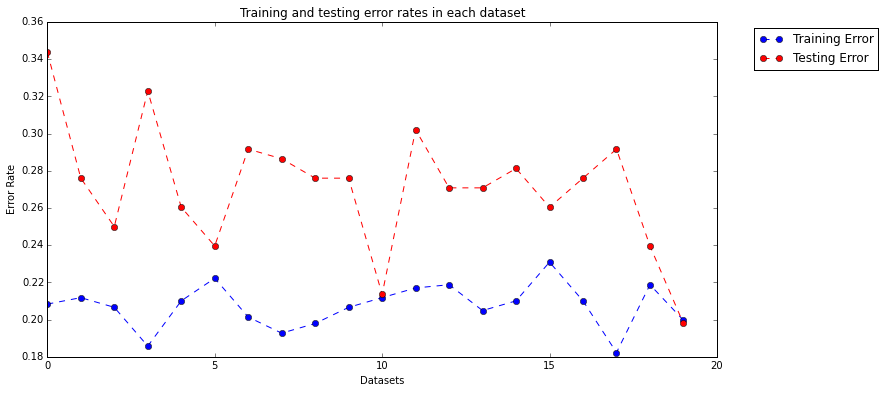

In [24]:
nb = NB(features=[0,1,2,3,4,5,6,7], disc_type='EWD')
nb_tr_err, nb_ts_err = solve_clf(nb, 'diabetes', params=nb_params, show=[2,15])

### 2) Perceptrón Dual con kernel gaussiano

In [25]:
dp_params = {'eta':np.linspace(0.001,0.1,5,endpoint=True), 'gamma':np.linspace(0.5,10.,5,endpoint=True)}

##############################################################
Dataset: 2
Best parameter: {'eta': 0.10000000000000001, 'gamma': 0.5}
CV scores:
mean: 0.69271, std: 0.03123, params: {'eta': 0.001, 'gamma': 0.5}
mean: 0.64410, std: 0.03004, params: {'eta': 0.001, 'gamma': 2.875}
mean: 0.64931, std: 0.02772, params: {'eta': 0.001, 'gamma': 5.25}
mean: 0.66493, std: 0.01008, params: {'eta': 0.001, 'gamma': 7.625}
mean: 0.66667, std: 0.01047, params: {'eta': 0.001, 'gamma': 10.0}
mean: 0.70312, std: 0.04891, params: {'eta': 0.025750000000000002, 'gamma': 0.5}
mean: 0.67188, std: 0.06040, params: {'eta': 0.025750000000000002, 'gamma': 2.875}
mean: 0.67535, std: 0.05883, params: {'eta': 0.025750000000000002, 'gamma': 5.25}
mean: 0.67535, std: 0.05608, params: {'eta': 0.025750000000000002, 'gamma': 7.625}
mean: 0.67708, std: 0.05610, params: {'eta': 0.025750000000000002, 'gamma': 10.0}
mean: 0.69271, std: 0.04962, params: {'eta': 0.050500000000000003, 'gamma': 0.5}
mean: 0.68056, std: 0.06172,

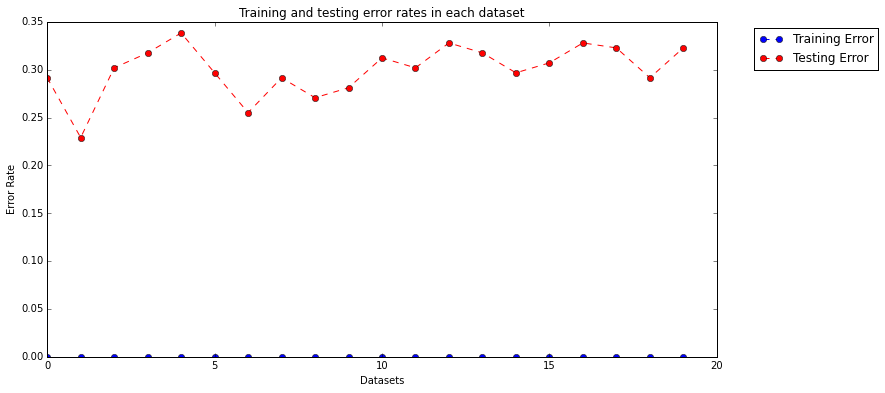

In [26]:
dp = DP()
dp_tr_err, dp_ts_err = solve_clf(dp, 'diabetes', params=dp_params, data_func=normalize, show=[2,15])

### 3) Nu-SVM con kernel gaussiano

In [28]:
ksvm_params = {'nu':np.array([0.1, 0.2, 0.3, 0.4, 0.5]), 'gamma':np.linspace(0.5,2.,5,endpoint=True)}

##############################################################
Dataset: 2
Best parameter: {'nu': 0.5, 'gamma': 0.5}
CV scores:
mean: 0.69965, std: 0.03971, params: {'nu': 0.10000000000000001, 'gamma': 0.5}
mean: 0.70312, std: 0.04429, params: {'nu': 0.20000000000000001, 'gamma': 0.5}
mean: 0.71354, std: 0.03952, params: {'nu': 0.29999999999999999, 'gamma': 0.5}
mean: 0.72396, std: 0.04047, params: {'nu': 0.40000000000000002, 'gamma': 0.5}
mean: 0.73958, std: 0.03139, params: {'nu': 0.5, 'gamma': 0.5}
mean: 0.68924, std: 0.03735, params: {'nu': 0.10000000000000001, 'gamma': 0.875}
mean: 0.68403, std: 0.03493, params: {'nu': 0.20000000000000001, 'gamma': 0.875}
mean: 0.68229, std: 0.03864, params: {'nu': 0.29999999999999999, 'gamma': 0.875}
mean: 0.69097, std: 0.04146, params: {'nu': 0.40000000000000002, 'gamma': 0.875}
mean: 0.69965, std: 0.03632, params: {'nu': 0.5, 'gamma': 0.875}
mean: 0.66146, std: 0.02876, params: {'nu': 0.10000000000000001, 'gamma': 1.25}
mean: 0.66146, std: 0.028

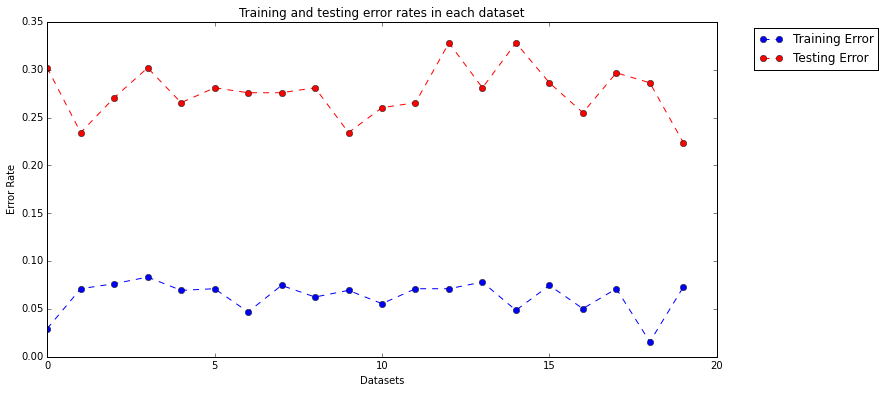

In [29]:
ksvm = svm.NuSVC(kernel='rbf')
ksvm_tr_err, ksvm_ts_err = solve_clf(ksvm, 'diabetes', params=ksvm_params, data_func=normalize, show=[2,15])

### 4) Comparación de resultados

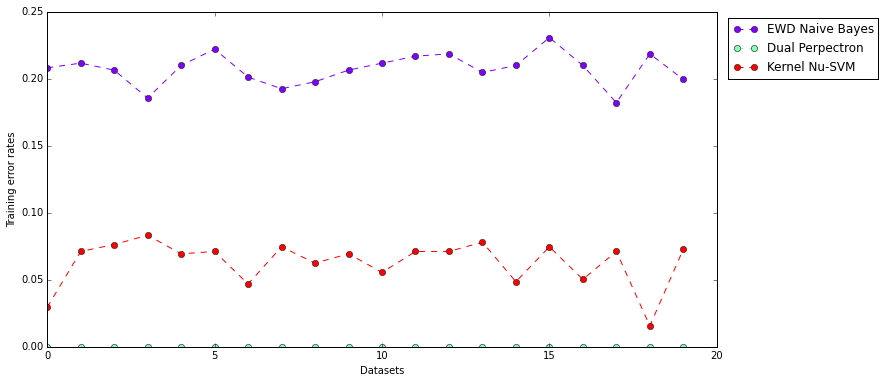

In [58]:
errors = [nb_tr_err, dp_tr_err, ksvm_tr_err]
labels = ['EWD Naive Bayes', 'Dual Perpectron', 'Kernel Nu-SVM']
comparative_plot(errors, labels, err_type='Training')

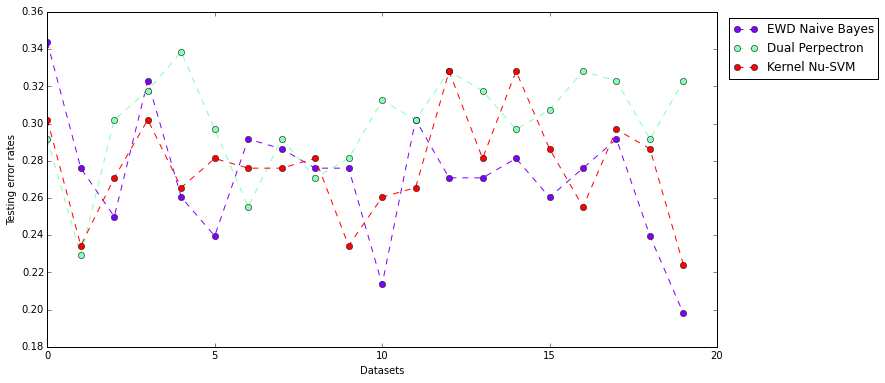

In [59]:
errors = [nb_ts_err, dp_ts_err, ksvm_ts_err]
labels = ['EWD Naive Bayes', 'Dual Perpectron', 'Kernel Nu-SVM']
comparative_plot(errors, labels, err_type='Testing')

### 5) Desempeño de algoritmo con conjuntos de entrenamientos reducidos

In [ ]:
params = {'nu':np.array([0.1, 0.2, 0.3, 0.4, 0.5]), 'gamma':np.linspace(0.5,2.,5,endpoint=True)}

In [ ]:
ksvm = svm.NuSVC(kernel='rbf')
ksvm100_tr_err, ksvm100_ts_err = solve_clf(ksvm, 'diabetes', ntr_data=100, params=params, data_func=normalize, show=[])

In [ ]:
ksvm = svm.NuSVC(kernel='rbf')
ksvm200_tr_err, ksvm200_ts_err = solve_clf(ksvm, 'diabetes', ntr_data=200, params=params, data_func=normalize, show=[])

In [ ]:
ksvm = svm.NuSVC(kernel='rbf')
ksvm300_tr_err, ksvm300_ts_err = solve_clf(ksvm, 'diabetes', ntr_data=300, params=params, data_func=normalize, show=[])

## Conclusiones

## Anexo de Código

### Configuración del notebook

In [20]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cross_validation import KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.grid_search import GridSearchCV

#setting some paths
path1 = './credit/'
#data directory
path2 = './diabetes/'

### Funciones para el manejo de la data

In [4]:
#Rescale features of M to [a,b] range
def rescale(M, a=0., b=1.):
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

#Normalize features of M
def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

## Métricas de error para clasificación

In [5]:
#precision
def precision(yreal, ypred):
    yr = yreal.astype(int)
    yp = ypred.astype(int)
    m, = yr.shape
    #number of good predictions/number of predictions
    return np.sum(yp==yr)/np.float(m)

#error rate 
def error_rate(yreal, ypred):
    return 1.-precision(yreal, ypred)

## Implementación de LDA

In [6]:
class LDA(BaseEstimator,ClassifierMixin):
    def __init__(self, alternative=False):
        self.alternative = alternative
    
    def fit(self, X, y):
        #boolean masks
        mask1 = y.astype(bool)
        mask0 = np.logical_not(mask1)
        #number of samples in each class
        M,N = X.shape
        M0 = np.sum(mask0)
        #estimates of probabilities
        p0 = M0/np.float(M)
        p1 = 1-p0
        #separating data by classes
        X0 = X[mask0]
        X1 = X[mask1]
        #estimates of means by traditional way
        if not self.alternative:
            u0 = np.mean(X0, axis=0)
            u1 = np.mean(X1, axis=0)
        #estimates of means by percentile method
        elif self.alternative:
            pinf0, psup0 = np.percentile(X0, [10 ,90], axis=0)
            pinf1, psup1 = np.percentile(X1, [10, 90], axis=0)
            #percentile mask arrays
            pmask0 = (pinf0 <= X0) & (X0 <= psup0)
            pmask1 = (pinf1 <= X1) & (X1 <= psup1)
            #means computation
            u0 = np.empty(N)
            u1 = np.empty(N)
            for j in xrange(N):
                u0[j] = np.mean(X0[:,j][pmask0[:,j]])
                u1[j] = np.mean(X1[:,j][pmask1[:,j]])
        #estimation of shared covariance matrix
        Y = X.copy()
        Y[mask0] -= u0
        Y[mask1] -= u1
        Cov = np.dot(Y.T,Y)
        Cov /= (M-2.)
        #computing parameters of linear discriminants
        self.w0 = np.linalg.solve(Cov,u0)
        self.b0 = np.log(p0) - 0.5*np.dot(u0, self.w0)
        self.w1 = np.linalg.solve(Cov,u1)
        self.b1 = np.log(p1) - 0.5*np.dot(u1, self.w1)
        return self
    
    def predict(self, X):
        #evaluation of discriminant hyperplane
        return (np.dot(X,self.w1-self.w0) > self.b0-self.b1)

## Implementación de Naive Bayes

In [7]:
class NB(BaseEstimator,ClassifierMixin):
    def __init__(self, disc_type='EWD', nbins=10, features=None):
        self.disc_type = disc_type
        self.nbins = nbins
        self.features = features
        
    #equal width discretization
    def EWD(self, x):
        #interval extremes tolerance on discretization
        eps = 1e-10
        bins =  np.linspace(x.min()-eps, x.max()+eps, self.nbins+1, endpoint=True)
        return bins
    
    #equal frequency discretization
    def EFD(self, x):
        #interval extremes tolerance on discretization
        eps = 1e-10
        #sort the array
        x = np.sort(x)
        M, = x.shape
        #frequency in each resulting bin
        freq = M/self.nbins
        bins = np.empty(self.nbins+1)
        for i in range(1,self.nbins):
            bins[i] = x[i*freq]
        bins[0] = x[0]-eps
        bins[-1] = x[-1]+eps
        return bins
    
    #Gauss distribution
    def gauss(self, x, mu, sigma):
        a = (1./np.sqrt(2*np.pi*sigma**2))
        return a*np.exp(-1*(x-mu)**2/(2*sigma**2))
    
    def fit(self, X, y):
        #boolean masks
        mask1 = y.astype(bool)
        mask0 = np.logical_not(mask1)
        #number of samples in each class
        M,N = X.shape
        M0 = np.sum(mask0)
        M1 = M-M0
        #estimates of probabilities
        p0 = M0/np.float(M)
        p1 = 1-p0
        #separating data by classes
        X0 = X[mask0]
        X1 = X[mask1]
        
        #computing means and std for gauss discretization
        if self.disc_type=='Gauss':
            self.mu0 = np.mean(X0, axis=0)
            self.mu1 = np.mean(X1, axis=0)
            self.sigma0 = np.std(X0, axis=0)
            self.sigma1 = np.std(X1, axis=0)
        
        #conditional probabilities of features in each class
        CP0 = list()
        CP1 = list()
        #matrix of bins for each non-discrete feature
        B0 = np.empty((len(self.features),self.nbins+1))
        B1 = np.empty((len(self.features),self.nbins+1))
        #index of bins matrices
        ind = 0
        
        #computing conditional probabilities of features
        for f in xrange(N):
            #discretization needed
            if (f in self.features) and (self.disc_type in ['EWD','EFD']):
                f0 = X0[:,f]
                f1 = X1[:,f]
                if self.disc_type=='EWD':   bins0 = self.EWD(f0); bins1 = self.EWD(f1)
                elif self.disc_type=='EFD': bins0 = self.EFD(f0); bins1 = self.EFD(f1)
                frec0 = np.bincount(np.digitize(f0, bins0), minlength=self.nbins+2) + 1.
                frec1 = np.bincount(np.digitize(f1, bins1), minlength=self.nbins+2) + 1.
                CP0.append(frec0/(M0+self.nbins+2))
                CP1.append(frec1/(M1+self.nbins+2))
                B0[ind] = bins0
                B1[ind] = bins1
                ind += 1
            #no discretization needed
            else:
                f0 = X0[:,f].astype(int)
                f1 = X1[:,f].astype(int)
                frec0 = np.bincount(f0, minlength=np.max(f0)+1) + 1.
                frec1 = np.bincount(f1, minlength=np.max(f1)+1) + 1.
                CP0.append(frec0/(M0+np.max(f0)+1))
                CP1.append(frec1/(M1+np.max(f1)+1))        
        #storing needed data
        self.p0 = p0
        self.p1 = p1 
        self.CP0 = CP0
        self.CP1 = CP1
        self.B0 = B0
        self.B1 = B1
        return self
        
    def predict(self, X):
        M,N = X.shape
        prob0 = np.ones(M)
        prob1 = np.ones(M)
        #index of bins matrices
        ind1 = 0
        #index of CP, for gauss case
        ind2 = 0
        for f in xrange(N):
            #discretization needed
            if (f in self.features) and (self.disc_type in ['EWD','EFD']):
                tmp = X[:,f]
                tmp0 = np.digitize(tmp, self.B0[ind1]).astype(int)
                tmp1 = np.digitize(tmp, self.B1[ind1]).astype(int)
                prob0 *= (self.CP0[f])[tmp0]
                prob1 *= (self.CP1[f])[tmp1]
                ind1 +=1
            elif (f in self.features) and (self.disc_type in ['Gauss']):
                prob0 *= self.gauss(X[:,f], self.mu0[f], self.sigma0[f])
                prob1 *= self.gauss(X[:,f], self.mu1[f], self.sigma1[f])
                
            #no discretization needed
            elif (self.disc_type in ['EWD','EFD']):
                tmp = X[:,f].astype(int)
                prob0 *= (self.CP0[f])[tmp]
                prob1 *= (self.CP1[f])[tmp]
            elif (self.disc_type in ['Gauss']):
                tmp = X[:,f].astype(int)
                prob0 *= (self.CP0[ind2])[tmp]
                prob1 *= (self.CP1[ind2])[tmp]
                ind2 += 1
        prob0 *= self.p0
        prob1 *= self.p1
        return (prob0 < prob1).astype(int)
    
    #to make it compatible with scikit
    def score(self, X, y):
        return precision(y, self.predict(X))

## Implementación de Primal Perceptron

In [8]:
class PP(BaseEstimator,ClassifierMixin):
    def __init__(self, eta=0.01, n_iter=100000, tol=20):
        self.eta = eta
        self.n_iter = n_iter
        self.tol = tol
    
    def f(self, X):
        return np.dot(X,self.w)+self.b
    
    def fit(self, X, y):
        M,N = X.shape
        #initial guesses
        self.w = np.zeros(N)
        self.b = 0.
        #R parameter
        R = np.max(np.linalg.norm(X, axis=1))
        #error rate and counter
        err1 = error_rate(y, self.predict(X))
        c = 0
        
        for i in xrange(self.n_iter):
            #error rate at previous iteration
            err0 = err1
            for m in xrange(M):
                #if misclassified
                if y[m]*self.f(X[m])<=0:
                    self.w += self.eta*y[m]*X[m]
                    self.b += self.eta*y[m]*R**2
            err1 = error_rate(y, self.predict(X))
            #stopping criterions
            if err1==0.: break
            elif err0==err1:
                c += 1
                if c > self.tol: break
            else: c = 0
        #store the number of iterations needed
        self.it = i+1
        return self
        
    def predict(self, X):
        return np.sign(self.f(X))
    
    #to make it compatible with scikit
    def score(self, X, y):
        return precision(y, self.predict(X))

+ La primera vez que se implemento, en la regla de actualización para $b$ se puso equívocamente: $b \leftarrow b + \nu y_m R \ $    en vez de $R^2$, y los resultados obtenidos fueron mucho mejores.

## Implementación de Dual Perceptron

In [9]:
class DP(BaseEstimator,ClassifierMixin):
    def __init__(self, eta=0.01, gamma=0.5, n_iter=100000, tol=20):
        self.eta = eta
        self.gamma = gamma
        self.n_iter = n_iter
        self.tol = tol
        pass

    numba.jit()
    def fit(self, X, y):
        M,N = X.shape
        #store data
        self.X = X
        self.y = y
        #initial guesses
        self.alp = np.zeros(M)
        self.b = 0.
        #R parameter
        R = np.max(np.linalg.norm(X, axis=1))
        #precomputed kernel matrix
        self.K = rbf_kernel(X, gamma=self.gamma)
        #error rate and counter
        err1 = error_rate(y, self.predict(X))
        c = 0
        
        for i in xrange(self.n_iter):
            #error rate at previous iteration
            err0 = err1
            for m in xrange(M):
                #if misclassified
                if y[m]*(np.sum(self.alp*y*self.K[m])+self.b)<=0:
                    self.alp[m] += 1
                    self.b += self.eta*y[m]*R**2
            err1 = error_rate(y, self.predict(X))
            #stopping criterions
            if err1==0.: break
            elif err0==err1:
                c += 1
                if c > self.tol: break
            else: c = 0
        #store the number of iterations needed
        self.it = i+1
        return self
        
    def predict(self, X):
        if np.array_equal(X, self.X):
            K = self.K
        else:
            #compute the kernel matrix
            K = rbf_kernel(X, self.X, self.gamma)
        f = np.sum(self.alp*self.y*K, axis=1)+self.b
        return np.sign(f)
    
    #to make it compatible with GridSearch
    def score(self, X, y):
        return precision(y, self.predict(X))

## Funciones complementarias (helpers) para obtener resultados

In [ ]:
"""
Function to generate histogram of winners
"""
def make_hist(winners,params):
    winners = np.array(winners)
    freqs = np.zeros(5)
    for i in xrange(5):
        freqs[i] = np.sum(params[i]==winners)

    labels = map(str,params)
    pos = np.arange(len(labels))
    width = 1.0
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(5)
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(labels)
    plt.ylabel('Frequency')
    plt.title('Histogram of winner parameters')
    plt.bar(pos, freqs, width, color='0.5')
    plt.show()

    
def plot_error(tr_err, ts_err):
    x = np.arange(20)
    plt.figure(figsize=(12,6))
    plt.plot(x, tr_err, marker='o', linestyle='--', color='b', label='Training Error')
    plt.plot(x, ts_err, marker='o', linestyle='--', color='r', label='Testing Error')
    plt.xlabel('Datasets')
    plt.ylabel('Error Rate')
    plt.title('Training and testing error rates in each dataset')
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    plt.show()
    
    
def comparative_plot(errors, labels, err_type=None):
    x = np.arange(20)
    colors = cm.rainbow(np.linspace(0., 1., len(errors)))
    plt.figure(figsize=(12,6))
    for i in xrange(len(errors)):
        plt.plot(x, errors[i], marker='o', linestyle='--', color=colors[i], label=labels[i])
    plt.xlabel('Datasets')
    plt.ylabel(err_type+' error rates')
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    plt.show()
    

"""
Generate solutions for classification problems
"""
def solve_clf(clf, dataset, params=None, grid=None, ntr_data=None, data_func=None, show=None):   
    #set dataset name
    if dataset=='credit':
        path = './credit/credit'
    elif dataset=='diabetes':
        path = './diabetes/diabetes'
    else: return -1
    
    #error rates to plot
    tr_err = np.empty(20)
    ts_err = np.empty(20)
    
    #iterate through data
    for i in xrange(20):
        #loading datasets
        if ntr_data is not None:
            tr_file = path+'-tr-{0}-{1}.npy'.format(i, ntr_data)
        else:
            tr_file = path+'-tr-{0}.npy'.format(i)
        ts_file = path+'-ts-{0}.npy'.format(i)
            
        tr_data = np.load(tr_file)
        ts_data = np.load(ts_file)
        
        if data_func is not None:
            X_tr = data_func(tr_data[:,:-1])
            X_ts = data_func(ts_data[:,:-1])
        else: 
            X_tr = tr_data[:,:-1]
            X_ts = ts_data[:,:-1]
        y_tr = np.ascontiguousarray(tr_data[:,-1])
        y_ts = np.ascontiguousarray(ts_data[:,-1])
        if (type(clf) is PP) or (type(clf) is DP) or (type(clf) is svm.NuSVC):
            #change label for separating hyperplanes approaches
            y_tr[y_tr==0.] = -1
            y_ts[y_ts==0. ]= -1

        if params is not None:
            #tunning parameters
            gs = GridSearchCV(clf, params, cv=5, n_jobs=4)
            gs.fit(X_tr, y_tr)
            grid_scores = gs.grid_scores_
            best_params = gs.best_params_
            #traininig with best parameters
            clf.set_params(**best_params)
            clf.fit(X_tr, y_tr)
        else:
            clf.fit(X_tr, y_tr)
        
        #computing errors
        tr_err[i] = error_rate(y_tr, clf.predict(X_tr))
        ts_err[i] = error_rate(y_ts, clf.predict(X_ts))
        
        if (show is not None) and (i not in show): continue
        print "##############################################################"
        print "Dataset: {0}".format(i)
        if params is not None:
            print 'Best parameter: {0}'.format(best_params)
            print 'CV scores:'
            for result in grid_scores: print result
        print 'Training error: {0}'.format(tr_err[i])
        print 'Testing error: {0}'.format(ts_err[i])
        print "##############################################################"
        print '\n'
    
    #ploting errors
    if show: plot_error(tr_err, ts_err)
    return (tr_err,ts_err)